In [1]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos
import dill
from sympy import Symbol

In [2]:
gamma = 2*np.pi*84e6 # Hz
k = 2*np.pi/227.5e-9 # m^-1

t_unit = 1/gamma
# t_unit = 1e-9

m_unit = 1/k
# m_unit = 1e-9

velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*227.5e-9**3) # W/m^2

In [3]:
print(t_unit)
print(cm_unit)
print(velocity_unit)
print(accel_unit)

1.8947017034749446e-09
3.6207749553406186e-06
19.11
10086020382.496958


In [4]:
ksim=k*m_unit
gammasim=gamma/Hz_unit
print(ksim)
print(gammasim)

1.0
1.0000000000000002


# Q1

In [5]:
data = np.loadtxt("AlF_mat_elems/Q1_processed.dat", skiprows=2, delimiter="\t", usecols=(2,3,4,5,6,7,8), dtype=[("d","f8"),("Fe","i4"),("ne", "i4"),("Fg", "i4"),("ng", "i4"),("Ee","f8"),("Eg","f8")])

In [6]:
Ne = np.sum([2*F+1 for F in np.unique(data[["Fe","ne"]])["Fe"]])
Ng = np.sum([2*F+1 for F in np.unique(data[["Fg","ng"]])["Fg"]])
labels_e = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ne","Fe"]])])
labels_g = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ng","Fg"]])])

In [7]:
Ee = {(n, F) : (E - np.min(data['Ee']))*const.c*100 for n, F, E in data[['ne','Fe','Ee']]}
Eg = {(n, F) : (E - np.min(data['Eg']))*const.c*100 for n, F, E in data[['ng','Fg','Eg']]}

In [8]:
print(Ee)
print(Eg)

{(1, 2): 0.0, (1, 1): 96814946.40727651, (1, 3): 196168475.39040226, (2, 2): 213556288.0581749, (2, 3): 360500460.72424686, (1, 4): 439742142.8492313}
{(1, 3): 0.0, (1, 2): 4436.928379392962, (2, 3): 7891376.913445855, (2, 2): 11225938.444535434, (1, 1): 11247313.646788737, (1, 4): 7939883.333149686}


In [9]:
mu_q = {}
d_q = {}
H0 = {}

In [10]:
mu_q['X(v=0)'] = np.zeros((3,Ng,Ng))
#mu_q['X(v=1)'] = np.zeros((3,full_labels.shape[0],full_labels.shape[0]))
mu_q['A(v=0)'] = np.zeros((3,Ne,Ne))
H0['X(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Eg[(n, F)] for n, F, _ in labels_g])
#H0['X(v=1)'] = np.zeros((full_labels.shape[0],full_labels.shape[0]))
H0['A(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Ee[(n, F)] for n, F, _ in labels_e])

In [11]:
np.unique(data[["ng","Fg"]])

array([(1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3)],
      dtype={'names':['ng','Fg'], 'formats':['<i4','<i4'], 'offsets':[20,16], 'itemsize':40})

In [12]:
np.array([Eg[(n, F)] for n, F in data[["ng","Fg"]]])/2/np.pi/1e6

array([0.00000000e+00, 7.06159084e-04, 1.25595164e+00, 1.78666359e+00,
       1.79006556e+00, 7.06159084e-04, 1.78666359e+00, 1.79006556e+00,
       0.00000000e+00, 7.06159084e-04, 1.25595164e+00, 1.26367168e+00,
       1.78666359e+00, 0.00000000e+00, 7.06159084e-04, 1.25595164e+00,
       1.78666359e+00, 1.79006556e+00, 0.00000000e+00, 7.06159084e-04,
       1.25595164e+00, 1.26367168e+00, 1.78666359e+00, 0.00000000e+00,
       1.25595164e+00, 1.26367168e+00])

In [13]:
d = {(ne, Fe, ng, Fg) : d for ne, Fe, ng, Fg, d in data[['ne','Fe','ng','Fg','d']]}

In [14]:
dijq = np.array([[[(-1)**(Fe-Me)*float(wigner_3j(Fe,1,Fg,-Me,p,Mg))*d.get((ne, Fe, ng, Fg),0)*np.sqrt(2*Fe+1)/np.sqrt((np.sum([np.abs(d.get((ne, Fe, ngp, Fgp),0))**2 for ngp, Fgp in np.unique(data[["ng","Fg"]])]))) for ne, Fe, Me in labels_e]  for ng, Fg, Mg in labels_g] for p in [-1,0,1]])

In [15]:
class idx:
    def __init__(self,rmax=36):
        self.rmax =rmax
    def __getitem__(self, a):
        return np.concatenate([np.arange(self.rmax)[i] for i in a])

In [16]:
ids = idx()[0:3,3:8,24:29,8:15,29:36,15:24]
print(np.array2string(dijq[:,ids][:,:,ids],threshold=np.inf, separator=',').replace(" ","").replace("\n",""))

[[[0.,-0.,0.,-0.05505523,0.,-0.,0.,-0.,-0.66785852,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.35310312,-0.,0.,-0.,-0.03892993,-0.,0.,-0.,-0.,-0.47224729,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.35310312,0.,-0.,0.,-0.02247621,0.,-0.,-0.,0.,-0.2726521,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.27075745,0.,-0.,0.,-0.,0.,-0.,-0.518019,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.07277687,-0.,0.,-0.,0.,-0.16796935,0.,-0.,0.,-0.,-0.,-0.22107253,-0.,0.,-0.,0.,-0.,-0.,-0.42296075,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.26454644,-0.,0.,0.,0.0891331,0.,-0.,0.,-0.,-0.2057196,-0.,0.,-0.,-0.,0.,-0.17124205,0.,-0.,0.,-0.,-0.,0.,-0.32762399,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.45820787,0.,0.,-0.,0.0891331,-0.,0.,-0.,0.,-0.2057196,0.,-0.,-0.,0.,-0.,-0.12

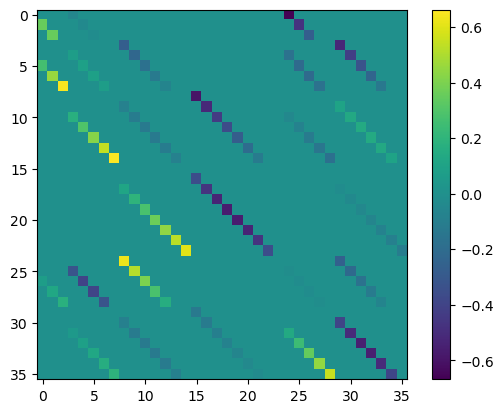

In [18]:
plt.imshow(dijq[0])
plt.colorbar()

In [ ]:
import dill

with open("AlF_Q1_dijq.dump", 'wb') as file:
    dill.dump(dijq,file)

In [16]:
d_q[("X(v=0)","A(v=0)")] = dijq

In [17]:
hamiltonian = pylcp.hamiltonian(mass=46/amu_unit, k=ksim, gamma=gammasim)
[hamiltonian.add_H_0_block(l, H) for l, H in H0.items()]
[hamiltonian.add_mu_q_block(l, mu, muB=1) for l, mu in mu_q.items()]
[hamiltonian.add_d_q_block(l[0],l[1], dq, k=ksim, gamma=gammasim) for l, dq in d_q.items()]
# hamiltonian.add_d_q_block("X(v=0)","A(v=0)",dijq,k=0,gamma=gammasim*0.99)
# hamiltonian.add_d_q_block("A(v=0)","X(v=1)",dijq,k=0,gamma=gammasim*0.01)
hamiltonian.print_structure()

[[((<X(v=0)|H_0|X(v=0)> 36x36), (<X(v=0)|mu_q|X(v=0)> 36x36))
  (<X(v=0)|d_q|A(v=0)> 36x36)]
 [(<A(v=0)|d_q|X(v=0)> 36x36)
  ((<A(v=0)|H_0|A(v=0)> 36x36), (<A(v=0)|mu_q|A(v=0)> 36x36))]]


In [18]:
def MOT_Beams_nov1(det_MOT, det_slower, repump_s, repump_delta, s=0.3, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1,0, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([-1,0, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0, -1, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0, 1, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':1, 'delta':det_MOT, 's':s},
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

In [19]:
no_mag_field = pylcp.fields.constantMagneticField(np.array([0,0,0]))

In [21]:
det = 2*np.pi*(Symbol("Delta"))*84e6/Hz_unit
s = 1
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,0,1]), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe = pylcp.obe(beams, no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [49]:
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2)*84e6/Hz_unit, 's':2}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

In [50]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1],[0]*35,[0]*36)))

In [ ]:
obe.evolve_density([0,200/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 3.66 s.                                               


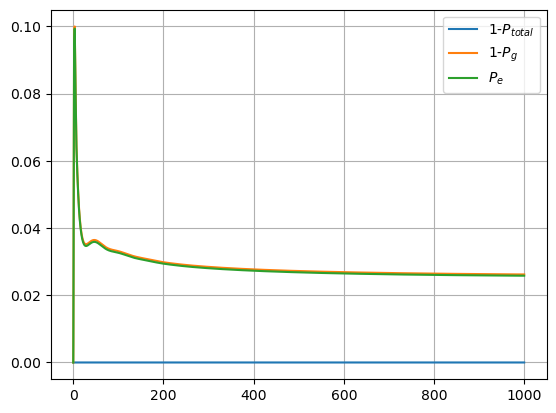

In [21]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-$P_{total}$")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-$P_g$")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="$P_e$")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [ ]:
obe_kwargs = dict(itermax=200, rel=1e-4, abs=0*(46*1.66e-27)/(F_unit), #deltat_func = lambda r, v : 1/gammasim+0*(1/gammasim if ksim/abs(v[0]) < 1/gammasim else 2*np.pi/ksim/abs(v[0])), deltat_r=np.inf,
                  deltat_tmax = 50/gammasim, deltat_r=np.inf,
                  Npts=10001, debug = False, rtol=1e-6, reset_pos = False,
                  atol=np.concatenate(([1e-5]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])))

Completed in 1:39:31.                                               


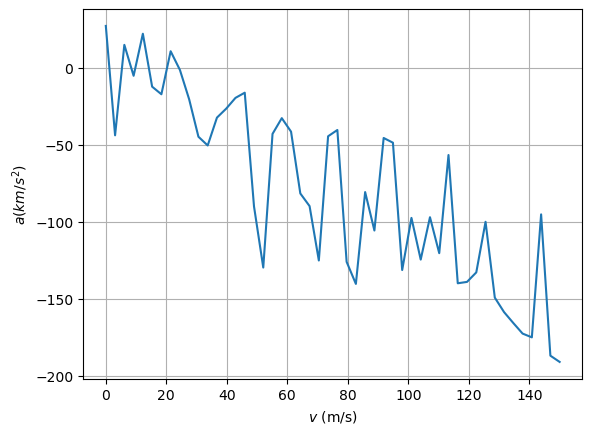

In [92]:
obe.laserBeams = MOT_Beams_nov1(2*np.pi*(-1)*84e6/Hz_unit,0,1,2*np.pi*205e6/Hz_unit)

R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-0/velocity_unit, 150/velocity_unit, 50) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v/np.sqrt(2),     v/np.sqrt(2),     np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, ((obe.profile['Frad'].F[0]+obe.profile['Frad'].F[1])/2)*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 12.09 s.                                               


Text(0, 0.5, '$P$')

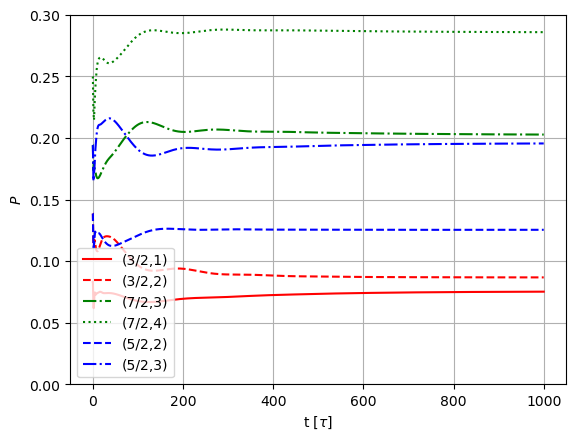

In [43]:
fig, ax = plt.subplots(1,1)
s = 8
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2)*84e6/Hz_unit, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/36]*36,[0]*36)))
obe.evolve_density([0,1000/gammasim],
                rtol=1e-6,
                atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                method="RK23",
                progress_bar=True);

ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,0:3],axis=1), 'r-', label=f"(3/2,1)")
ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,3:8],axis=1), 'r--', label=f"(3/2,2)")
ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,8:15],axis=1), 'g-.', label=f"(7/2,3)")
ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,15:24],axis=1), 'g:', label=f"(7/2,4)")
ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,24:29],axis=1), 'b--', label=f"(5/2,2)")
ax.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,29:36],axis=1), 'b-.', label=f"(5/2,3)")
ax.legend()
ax.grid()
ax.set_xlabel("t [$\\tau$]")
ax.set_ylim([0,0.3])
ax.set_ylabel("$P$")

Completed in 27.70 s.                                               


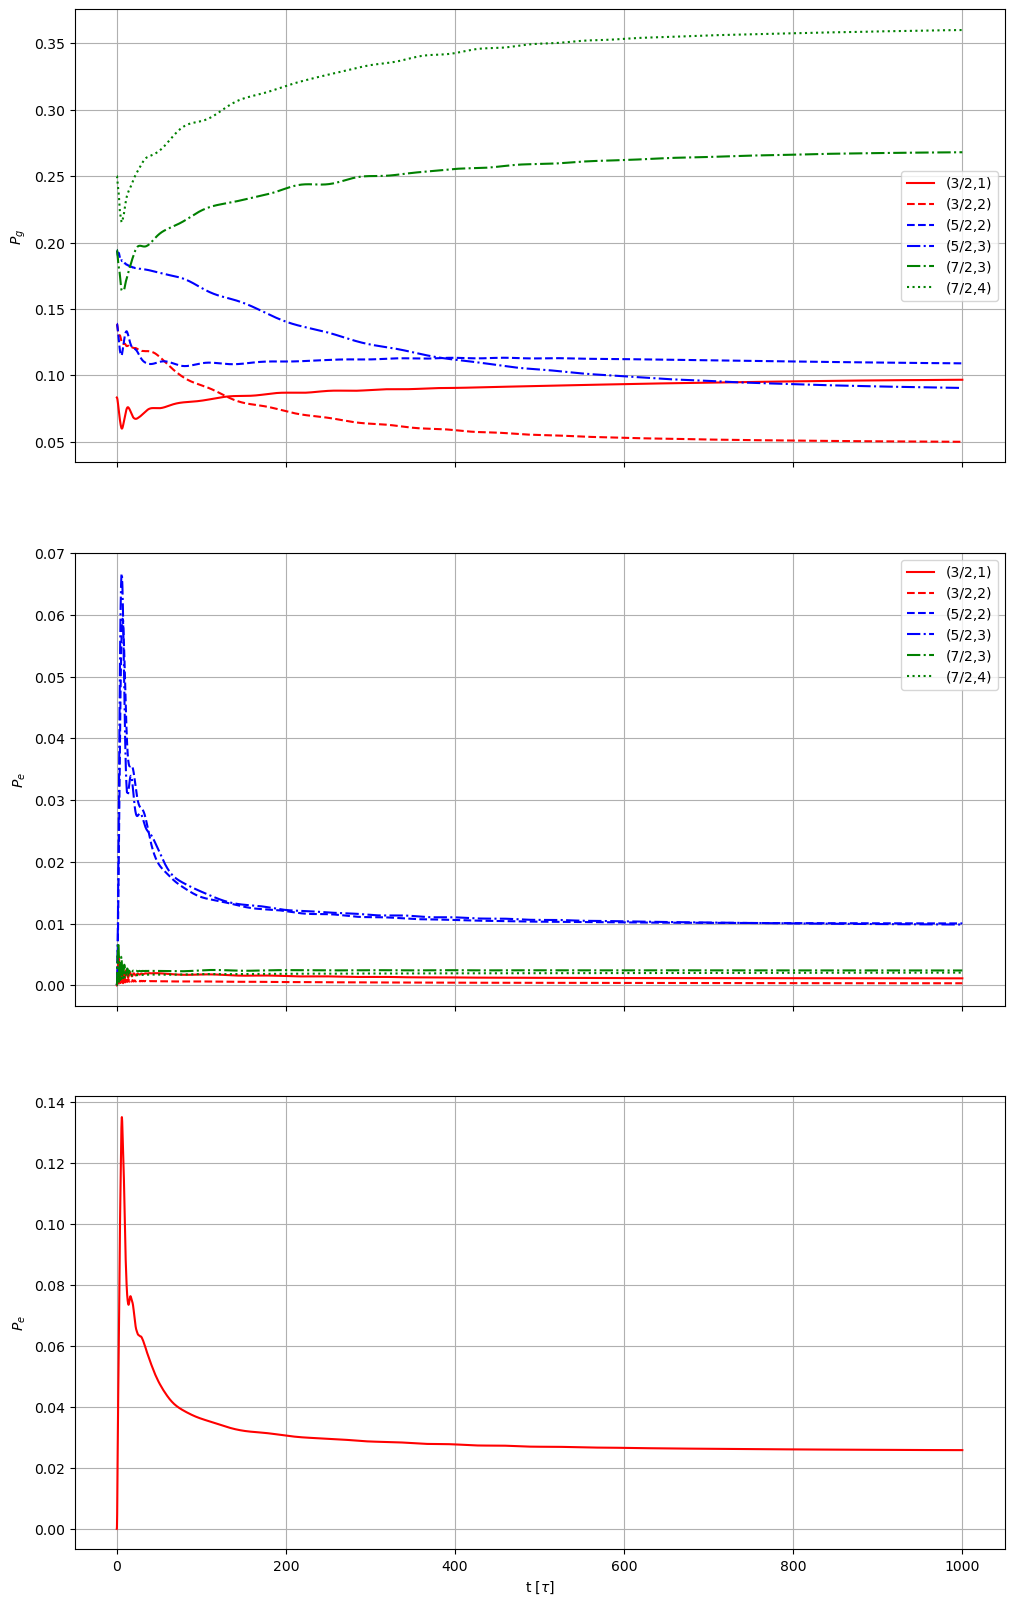

In [54]:
fig, (axa, axb, axc) = plt.subplots(3, 1, sharex=True, figsize=[12,20])
s = 8
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol': np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2.5)*84e6/Hz_unit, 's': s/2, 'wb' : 1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/36]*36,[0]*36)))
obe.evolve_density([0,1000/gammasim],
                rtol=1e-6,
                atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                method="RK23",
                progress_bar=True);

axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,0:3],axis=1), 'r-', label=f"(3/2,1)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,3:8],axis=1), 'r--', label=f"(3/2,2)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,24:29],axis=1), 'b--', label=f"(5/2,2)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,8:15],axis=1), 'b-.', label=f"(5/2,3)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,29:36],axis=1), 'g-.', label=f"(7/2,3)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,15:24],axis=1), 'g:', label=f"(7/2,4)")
axa.legend()
axa.grid()
# axa.set_xlabel("t [$\\tau$]")
# axa.set_ylim([0,0.3])
axa.set_ylabel("$P_g$")

axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,36:39],axis=1), 'r-', label=f"(3/2,1)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,39:44],axis=1), 'r--', label=f"(3/2,2)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,60:65],axis=1), 'b--', label=f"(5/2,2)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,44:51],axis=1), 'b-.', label=f"(5/2,3)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,65:72],axis=1), 'g-.', label=f"(7/2,3)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,51:60],axis=1), 'g:', label=f"(7/2,4)")
axb.legend()
axb.grid()
# axb.set_xlabel("t [$\\tau$]")
# axb.set_ylim([0,0.1])
axb.set_ylabel("$P_e$")
# axb.set_yscale('log')

axc.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,36:72],axis=1), 'r-')
axc.set_xlabel("t [$\\tau$]")
axc.set_ylabel("$P_e$")
axc.grid()

Completed in 27.47 s.                                               


Text(0, 0.5, '$P$')

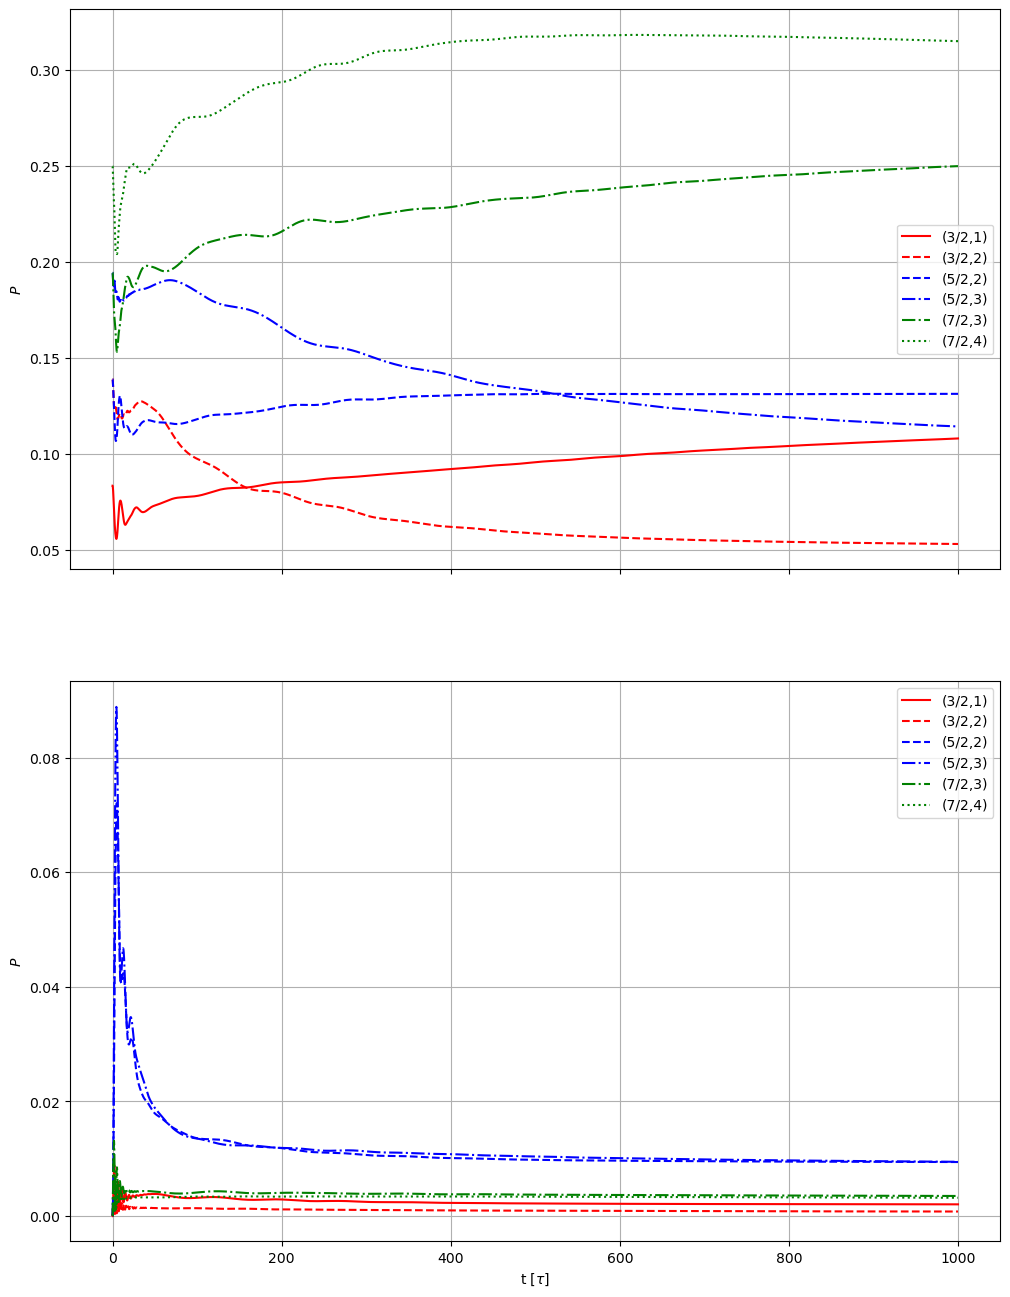

In [55]:
fig, (axa, axb) = plt.subplots(2, 1, sharex=True, figsize=[12,16])
s = 8
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2.5)*84e6/Hz_unit, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/36]*36,[0]*36)))
obe.evolve_density([0,1000/gammasim],
                rtol=1e-6,
                atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                method="RK23",
                progress_bar=True);

axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,0:3],axis=1), 'r-', label=f"(3/2,1)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,3:8],axis=1), 'r--', label=f"(3/2,2)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,24:29],axis=1), 'b--', label=f"(5/2,2)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,8:15],axis=1), 'b-.', label=f"(5/2,3)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,29:36],axis=1), 'g-.', label=f"(7/2,3)")
axa.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,15:24],axis=1), 'g:', label=f"(7/2,4)")
axa.legend()
axa.grid()
# axa.set_xlabel("t [$\\tau$]")
# axa.set_ylim([0,0.3])
axa.set_ylabel("$P$")

axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,36:39],axis=1), 'r-', label=f"(3/2,1)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,39:44],axis=1), 'r--', label=f"(3/2,2)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,60:65],axis=1), 'b--', label=f"(5/2,2)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,44:51],axis=1), 'b-.', label=f"(5/2,3)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,65:72],axis=1), 'g-.', label=f"(7/2,3)")
axb.plot(obe.sol.t*gammasim, np.sum(np.diagonal(obe.sol.rho)[:,51:60],axis=1), 'g:', label=f"(7/2,4)")
axb.legend()
axb.grid()
axb.set_xlabel("t [$\\tau$]")
# axb.set_ylim([0,0.1])
axb.set_ylabel("$P$")
# axb.set_yscale('log')

Completed in 2.94 s.                                               
Completed in 3.71 s.                                               
Completed in 4.04 s.                                               
Completed in 4.48 s.                                               
Completed in 3.65 s.                                               
Completed in 3.84 s.                                               
Completed in 3.80 s.                                               


Text(0, 0.5, '$P_e$')

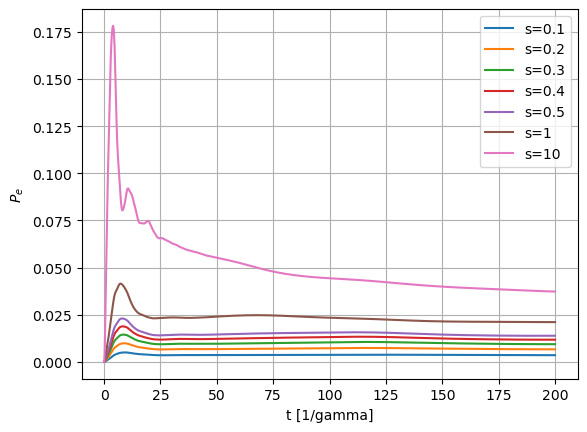

In [56]:
fig, ax = plt.subplots(1,1)
for s in [0.1,0.2,0.3,0.4,0.5,1,10]:
    obe.laserBeams = {
        'X(v=0)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2)*84e6/Hz_unit, 's':s}
        ], beam_type=pylcp.infinitePlaneWaveBeam)}
    obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
    obe.set_initial_rho_from_populations(np.concatenate(([1/36]*36,[0]*36)))
    obe.evolve_density([0,200/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);
    ax.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label=f"s={s}")
ax.legend()
ax.grid()
ax.set_xlabel("t [1/gamma]")
ax.set_ylabel("$P_e$")

Completed in 2.56 s.                                               
Completed in 3.63 s.                                               
Completed in 3.39 s.                                               
Completed in 3.40 s.                                               
Completed in 3.58 s.                                               
Completed in 3.79 s.                                               
Completed in 4.23 s.                                               


Text(0, 0.5, '$P_e$')

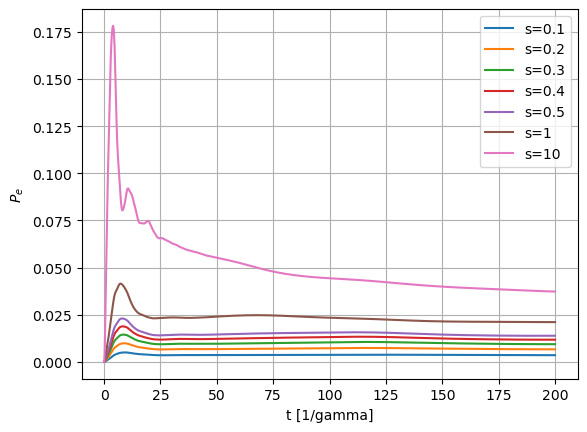

In [57]:
fig, ax = plt.subplots(1,1)
for s in [0.1,0.2,0.3,0.4,0.5,1,10]:
    obe.laserBeams = {
        'X(v=0)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0]), 'pol_coord': 'cartesian', 'delta':2*gamma/Hz_unit, 's':s}
        ], beam_type=pylcp.infinitePlaneWaveBeam)}
    obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
    obe.set_initial_rho_from_populations(np.concatenate(([1/36]*36,[0]*36)))
    obe.evolve_density([0,200/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);
    ax.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label=f"s={s}")
ax.legend()
ax.grid()
ax.set_xlabel("t [1/gamma]")
ax.set_ylabel("$P_e$")

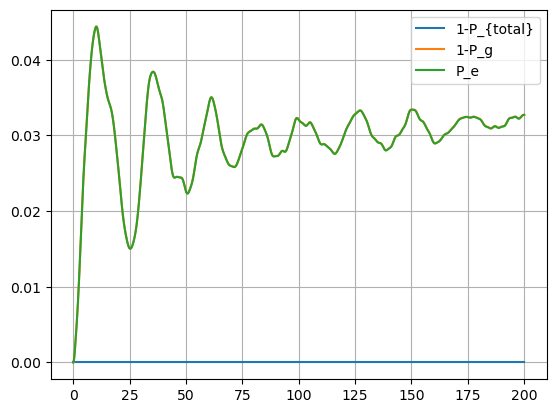

In [41]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

c:\Users\LP618\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


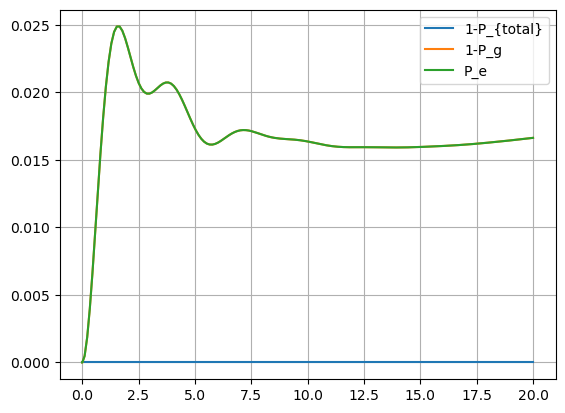

In [19]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

# Q2

In [26]:
data = np.loadtxt("AlF_mat_elems/Q2_processed.dat", skiprows=2, delimiter="\t", usecols=(2,3,4,5,6,7,8), dtype=[("d","f8"),("Fe","i4"),("ne", "i4"),("Fg", "i4"),("ng", "i4"),("Ee","f8"),("Eg","f8")])

In [27]:
Ne = np.sum([2*F+1 for F in np.unique(data[["Fe","ne"]])["Fe"]])
Ng = np.sum([2*F+1 for F in np.unique(data[["Fg","ng"]])["Fg"]])
labels_e = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ne","Fe"]])])
labels_g = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ng","Fg"]])])

In [28]:
Ee = {(n, F) : (E - np.min(data['Ee']))*const.c*100 for n, F, E in data[['ne','Fe','Ee']]}
Eg = {(n, F) : (E - np.min(data['Eg']))*const.c*100 for n, F, E in data[['ng','Fg','Eg']]}

In [29]:
print(Ee)
print(Eg)

{(2, 1): 0.0, (3, 2): 47217312.13500977, (1, 0): 62986395.425803915, (3, 1): 85111078.82620774, (3, 3): 113801217.05681062, (4, 2): 126752251.24241027, (4, 3): 182633565.41360623, (2, 4): 194895076.94580272, (3, 4): 244900458.9402028, (1, 5): 294905840.93460286}
{(1, 0): 12021677.565789556, (2, 1): 11991698.31999868, (1, 1): 7195018.991993883, (3, 2): 7195018.991993883, (2, 2): 1858713.239593538, (3, 3): 1858713.239593538, (2, 3): 0.0, (2, 4): 7254977.483602262, (1, 4): 29979.24579087698, (1, 5): 7344915.221001521}


In [30]:
mu_q = {}
d_q = {}
H0 = {}

In [31]:
mu_q['X(v=0)'] = np.zeros((3,Ng,Ng))
#mu_q['X(v=1)'] = np.zeros((3,full_labels.shape[0],full_labels.shape[0]))
mu_q['A(v=0)'] = np.zeros((3,Ne,Ne))
H0['X(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Eg[(n, F)] for n, F, _ in labels_g])
#H0['X(v=1)'] = np.zeros((full_labels.shape[0],full_labels.shape[0]))
H0['A(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Ee[(n, F)] for n, F, _ in labels_e])

In [32]:
d = {(ne, Fe, ng, Fg) : d for ne, Fe, ng, Fg, d in data[['ne','Fe','ng','Fg','d']]}

In [33]:
dijq = np.array([[[(-1)**(Fe-Me)*float(wigner_3j(Fe,1,Fg,-Me,p,Mg))*d.get((ne, Fe, ng, Fg),0)*np.sqrt(2*Fe+1)/np.sqrt((np.sum([np.abs(d.get((ne, Fe, ngp, Fgp),0))**2 for ngp, Fgp in np.unique(data[["ng","Fg"]])]))) for ne, Fe, Me in labels_e]  for ng, Fg, Mg in labels_g] for p in [-1,0,1]])

In [34]:
d_q[("X(v=0)","A(v=0)")] = dijq

In [35]:
hamiltonian = pylcp.hamiltonian(mass=46/amu_unit, k=ksim, gamma=gammasim)
[hamiltonian.add_H_0_block(l, H) for l, H in H0.items()]
[hamiltonian.add_mu_q_block(l, mu, muB=1) for l, mu in mu_q.items()]
[hamiltonian.add_d_q_block(l[0],l[1], dq, k=ksim, gamma=gammasim) for l, dq in d_q.items()]
# hamiltonian.add_d_q_block("X(v=0)","A(v=0)",dijq,k=0,gamma=gammasim*0.99)
# hamiltonian.add_d_q_block("A(v=0)","X(v=1)",dijq,k=0,gamma=gammasim*0.01)
hamiltonian.print_structure()

[[((<X(v=0)|H_0|X(v=0)> 60x60), (<X(v=0)|mu_q|X(v=0)> 60x60))
  (<X(v=0)|d_q|A(v=0)> 60x60)]
 [(<A(v=0)|d_q|X(v=0)> 60x60)
  ((<A(v=0)|H_0|A(v=0)> 60x60), (<A(v=0)|mu_q|A(v=0)> 60x60))]]


In [36]:
no_mag_field = pylcp.fields.constantMagneticField(np.array([0,0,0]))

## s=0.1

In [37]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 10
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,0,1]), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe = pylcp.obe(beams, no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

Completed in 2:07.                                                  


c:\Users\LP618\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Completed in 2:10.                                                  
Completed in 2:18.                                                  
Completed in 2:21.                                                  
Completed in 2:26.                                                  
Completed in 2:32.                                                  
Completed in 2:40.                                                  
Completed in 2:45.                                                  


Text(0, 0.5, '$P_e$')

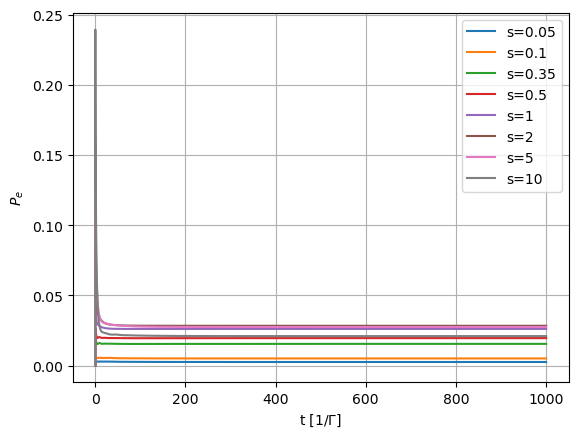

In [38]:
fig, ax = plt.subplots(1,1)
sols = []
for s in [0.05, 0.1, 0.35, 0.5, 1, 2, 5, 10]:
    obe.laserBeams = {
        'X(v=0)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,0,1]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(2)*84e6/Hz_unit, 's':s}
        ], beam_type=pylcp.infinitePlaneWaveBeam)}
    obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
    obe.set_initial_rho_from_populations(np.concatenate(([1/60]*60,[0]*60)))
    obe.evolve_density([0,2*np.pi*1000/gammasim],
                    rtol=1e-9,
                    atol=np.concatenate(([1e-6]*120*120,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="DOP853",
                    progress_bar=True);
    
    ax.plot(obe.sol.t/2/np.pi, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label=f"s={s}")
    sols.append(obe.sol)
ax.legend()
ax.grid()
ax.set_xlabel("t [$1/\\Gamma$]")
ax.set_ylabel("$P_e$")

Text(0, 0.5, '$P_e$')

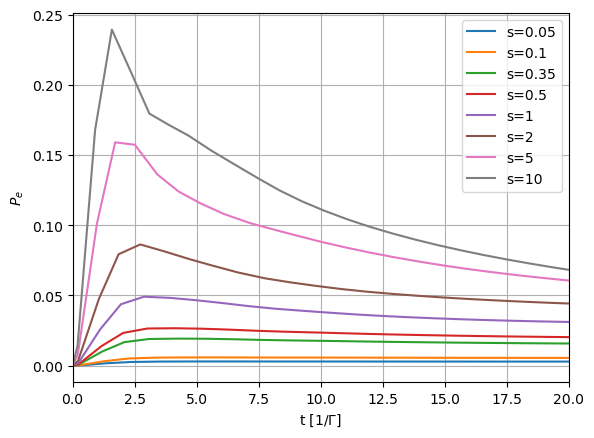

In [39]:
fig, ax = plt.subplots(1,1)
[ax.plot(sol.t, np.sum(np.diagonal(sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label=f"s={s}") for sol, s in zip(sols,[0.05, 0.1, 0.35, 0.5, 1, 2, 5, 10])]
ax.legend()
ax.grid()
ax.set_xlim([0,20])
ax.set_xlabel("t [$1/\\Gamma$]")
ax.set_ylabel("$P_e$")

Text(0, 0.5, '$P_e$')

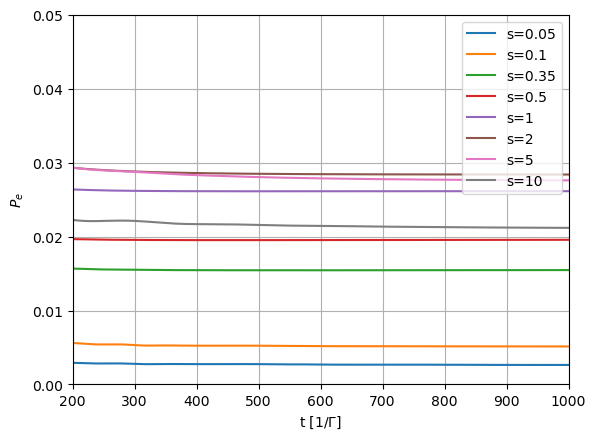

In [40]:
fig, ax = plt.subplots(1,1)
[ax.plot(sol.t, np.sum(np.diagonal(sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label=f"s={s}") for sol, s in zip(sols,[0.05, 0.1, 0.35, 0.5, 1, 2, 5, 10])]
ax.legend()
ax.grid()
ax.set_xlim([200,1000])
ax.set_ylim([0,0.05])
ax.set_xlabel("t [$1/\\Gamma$]")
ax.set_ylabel("$P_e$")

In [18]:
import pathos
res=[]
deltas = np.linspace(0,4,21)
for delta in deltas:
    obe.laserBeams = {
        'X(v=0)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,0,1]), 'pol_coord': 'cartesian', 'delta':2*np.pi*(delta)*84e6/Hz_unit, 's':1}
        ], beam_type=pylcp.infinitePlaneWaveBeam)}
    obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
    obe.set_initial_rho_from_populations(np.concatenate(([1/60]*60,[0]*60)))
    obe.evolve_density([0,1000/gammasim],
                    rtol=1e-9,
                    atol=np.concatenate(([1e-6]*120*120,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="DOP853",
                    progress_bar=True);
    res.append(np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1)[-1])
fig, ax = plt.subplots(1,1)
ax.plot(deltas, res)
# ax.legend()
ax.set_ylim([900,1000])
ax.grid()
ax.set_xlabel("$\\delta$ [$\\Gamma$]")
ax.set_ylabel("$P_e$")

Completed in 15.96 s.                                               


KeyboardInterrupt: 

In [86]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [87]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-13,
                    atol=np.concatenate(([1e-10]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="DOP853",
                    progress_bar=True);

Completed in 8.12 s.                                                


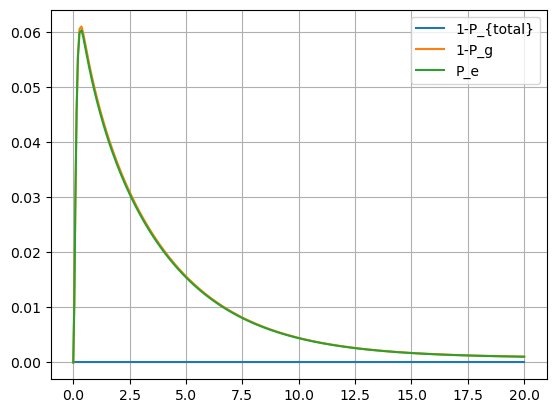

In [90]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

Completed in 13.10 s.                                               


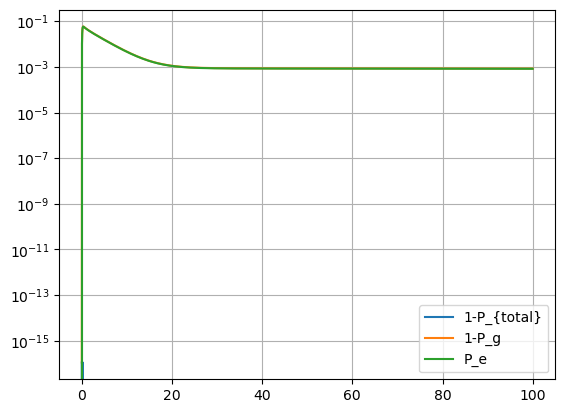

In [101]:
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))
obe.evolve_density([0,100/gammasim],
                    rtol=1e-13,
                    atol=np.concatenate(([1e-10]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="DOP853",
                    progress_bar=True);
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

## s=0.1

In [16]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 0.1
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,0,1]), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


In [17]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [18]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 2.01 s.                                               


c:\Users\LP618\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


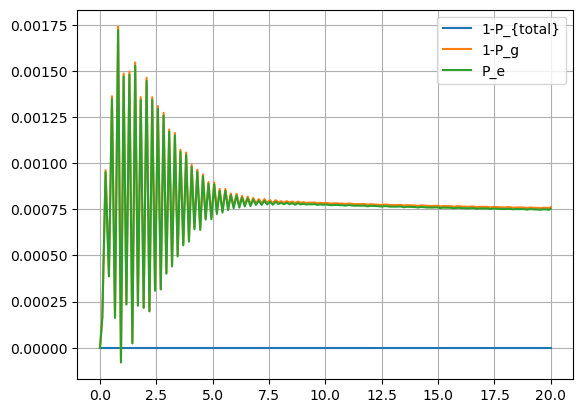

In [19]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [20]:
import dill
with open("AlF_Q2_s0.1.dump", 'wb') as file:
    dill.dump(obe,file)

## s=0.35

In [21]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 0.35
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


In [22]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [23]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.10 s.                                               


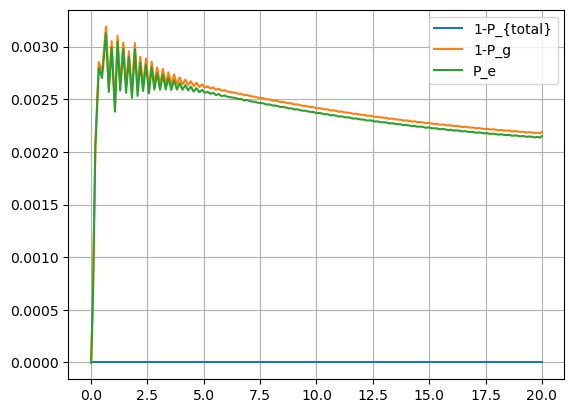

In [24]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [25]:
import dill
with open("AlF_Q2_s0.35.dump", 'wb') as file:
    dill.dump(obe,file)

## s=1

In [26]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 1
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


In [27]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [28]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.16 s.                                               


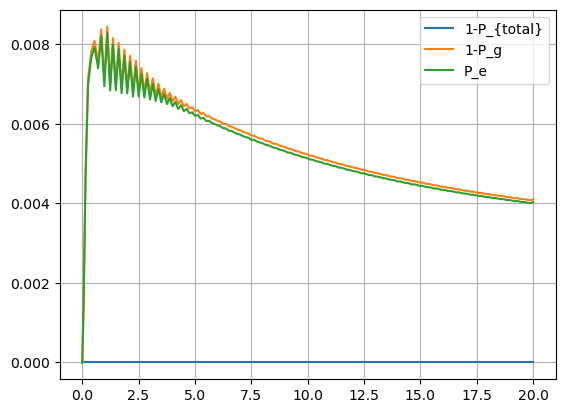

In [29]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [30]:
import dill
with open("AlF_Q2_s1.dump", 'wb') as file:
    dill.dump(obe,file)

## s=10

In [31]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 10
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


In [32]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [33]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.11 s.                                               


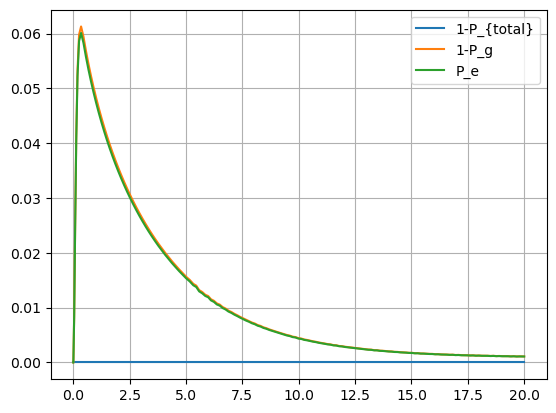

In [34]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [35]:
import dill
with open("AlF_Q2_s10.dump", 'wb') as file:
    dill.dump(obe,file)

## s=10 Det=0

In [36]:
det = 2*np.pi*(0)*84e6/Hz_unit
s = 10
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


In [37]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [38]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.18 s.                                               


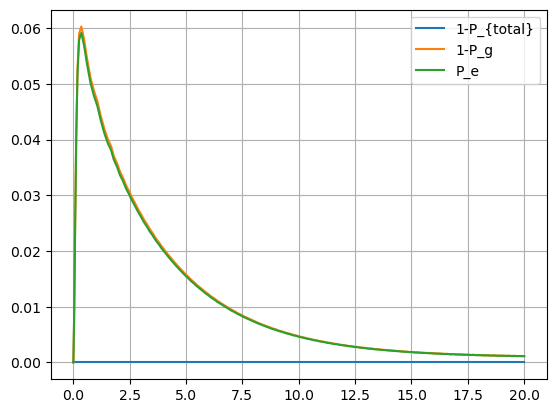

In [39]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [41]:
import dill
with open("AlF_Q2_s10_d0.dump", 'wb') as file:
    dill.dump(obe,file)

## s=10 Det=1

In [43]:
det = 2*np.pi*(1)*84e6/Hz_unit
s = 10
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,0])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe.laserBeams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':2*np.pi*(0)*84e6/Hz_unit, 's':10}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}


MemoryError: Unable to allocate 9.27 GiB for an array with shape (3, 14400, 14400) and data type complex128

In [ ]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [ ]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.18 s.                                               


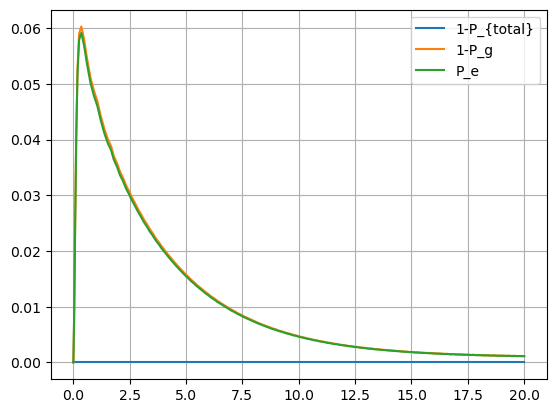

In [ ]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

In [ ]:
import dill
with open("AlF_Q2_s10_d1.dump", 'wb') as file:
    dill.dump(obe,file)

# Q3

In [108]:
data = np.loadtxt("AlF_mat_elems/Q3_processed.dat", skiprows=2, delimiter="\t", usecols=(2,3,4,5,6,7,8), dtype=[("d","f8"),("Fe","i4"),("ne", "i4"),("Fg", "i4"),("ng", "i4"),("Ee","f8"),("Eg","f8")])

In [109]:
Ne = np.sum([2*F+1 for F in np.unique(data[["Fe","ne"]])["Fe"]])
Ng = np.sum([2*F+1 for F in np.unique(data[["Fg","ng"]])["Fg"]])
labels_e = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ne","Fe"]])])
labels_g = np.concatenate([[[n, F, MF] for MF in range(-F, F+1)] for n, F in np.unique(data[["ng","Fg"]])])

In [110]:
Ee = {(n, F) : (E - np.min(data['Ee']))*const.c*100 for n, F, E in data[['ne','Fe','Ee']]}
Eg = {(n, F) : (E - np.min(data['Eg']))*const.c*100 for n, F, E in data[['ng','Fg','Eg']]}

In [111]:
print(Ee)
print(Eg)

{(2, 0): 0.0, (4, 1): 12771158.710801123, (5, 2): 37504036.49579674, (5, 1): 58639404.78479541, (5, 3): 72549774.835996, (6, 2): 81783382.54238194, (6, 3): 113561383.09040375, (4, 4): 115390117.0841931, (5, 4): 150555772.4075825, (2, 5): 162397574.49858683, (3, 5): 188479518.34458464, (1, 6): 223015609.50619254}
{(3, 1): 11242217.175000425, (2, 1): 7854562.399579564, (1, 0): 11182258.683392044, (4, 2): 7884541.645383755, (3, 2): 3477592.5127801793, (4, 3): 3537551.00438856, (3, 3): 0.0, (3, 4): 119916.98319013482, (2, 4): 29979.245777563516, (2, 5): 6955185.025586985, (1, 5): 149896.22899432527, (1, 6): 7105081.254581311}


In [112]:
mu_q = {}
d_q = {}
H0 = {}

In [113]:
mu_q['X(v=0)'] = np.zeros((3,Ng,Ng))
#mu_q['X(v=1)'] = np.zeros((3,full_labels.shape[0],full_labels.shape[0]))
mu_q['A(v=0)'] = np.zeros((3,Ne,Ne))
H0['X(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Eg[(n, F)] for n, F, _ in labels_g])
#H0['X(v=1)'] = np.zeros((full_labels.shape[0],full_labels.shape[0]))
H0['A(v=0)'] = (2*np.pi/Hz_unit)*np.diag([Ee[(n, F)] for n, F, _ in labels_e])

In [114]:
d = {(ne, Fe, ng, Fg) : d for ne, Fe, ng, Fg, d in data[['ne','Fe','ng','Fg','d']]}

In [115]:
dijq = np.array([[[(-1)**(Fe-Me)*float(wigner_3j(Fe,1,Fg,-Me,p,Mg))*d.get((ne, Fe, ng, Fg),0) for ng, Fg, Mg in labels_g] for ne, Fe, Me in labels_e] for p in [-1,0,1]])

In [116]:
d_q[("X(v=0)","A(v=0)")] = dijq

In [117]:
hamiltonian = pylcp.hamiltonian(mass=46/amu_unit, k=ksim, gamma=gammasim)
[hamiltonian.add_H_0_block(l, H) for l, H in H0.items()]
[hamiltonian.add_mu_q_block(l, mu, muB=1) for l, mu in mu_q.items()]
[hamiltonian.add_d_q_block(l[0],l[1], dq, k=ksim, gamma=gammasim) for l, dq in d_q.items()]
# hamiltonian.add_d_q_block("X(v=0)","A(v=0)",dijq,k=0,gamma=gammasim*0.99)
# hamiltonian.add_d_q_block("A(v=0)","X(v=1)",dijq,k=0,gamma=gammasim*0.01)
hamiltonian.print_structure()

[[((<X(v=0)|H_0|X(v=0)> 84x84), (<X(v=0)|mu_q|X(v=0)> 84x84))
  (<X(v=0)|d_q|A(v=0)> 84x84)]
 [(<A(v=0)|d_q|X(v=0)> 84x84)
  ((<A(v=0)|H_0|A(v=0)> 84x84), (<A(v=0)|mu_q|A(v=0)> 84x84))]]


In [118]:
no_mag_field = pylcp.fields.constantMagneticField(np.array([0,0,0]))

In [119]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 1
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe = pylcp.obe(beams, no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

MemoryError: Unable to allocate 11.9 GiB for an array with shape (28224, 28224) and data type complex128

In [ ]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1/labels_g.shape[0]]*labels_g.shape[0],[0]*labels_e.shape[0])))

In [ ]:
obe.evolve_density([0,20/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*(labels_g.shape[0]+labels_e.shape[0])*(labels_g.shape[0]+labels_e.shape[0]),[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);

Completed in 1.31 s.                                               


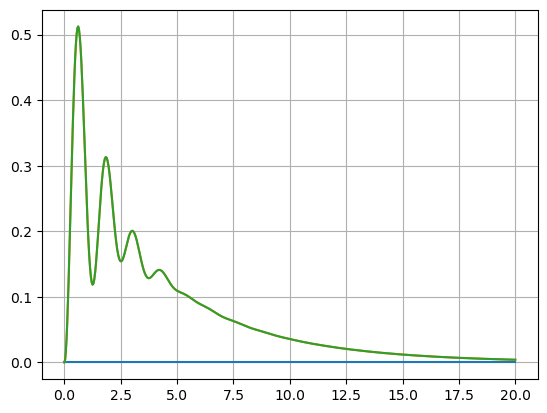

In [ ]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="1-P_{total}")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:(labels_g.shape[0])],axis=1), label="1-P_g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,(labels_g.shape[0]):-1],axis=1), label="P_e")
plt.legend()
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()